# Red Neuronal para Análisis de sentimientos
En el jupyter notebook se puede ver la construcción de un modelo SVM que predice el sentimiento de un comentario de redes sociales para dos productos ecuatorianos. Incluye la limpieza de datos, su preprocesamiento, preparación, construcción del modelo y evaluación del modelo.

In [2]:
import pandas as pd     #permite manipular datos
import numpy as np      #permite manipular números y matrices
import seaborn as sns   #permite manipulacion mediante graficos
sns.set_style("dark")   
import re               #proporciona coincidir con expresiones regulares
import string           #permite trabajos con formatos str
from string import punctuation
import nltk             #permite la utilzación de natural lenguaje toolkit
from nltk.corpus import stopwords  #bolsa de palabras stopwords
#nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier   #clasificador
from sklearn.neighbors import KNeighborsClassifier    #clasificador
 
import matplotlib.pyplot as plt                               #librería de gráficos
from sklearn.model_selection import train_test_split         #permite entrenamiento de la data
from sklearn.feature_extraction.text import CountVectorizer  #convertir token a vector
from sklearn.feature_extraction.text import TfidfTransformer #utilizado para normalizar matrices 

import tensorflow as tf                                        #manejo con redes neuronales 
from tensorflow.keras.models import Sequential                 #manejo con redes neuronales 
from tensorflow.keras.layers import Dense, Activation, Dropout #manejo con redes neuronales 
from tensorflow.keras.callbacks import EarlyStopping           #manejo con redes neuronales 
import tensorflow.keras.metrics                                #manejo con redes neuronales 

from sklearn.model_selection import GridSearchCV               #optimizacion de hiperparámetros
#from keras.models import Sequential, Model                     #manejo con redes neuronales 
from keras.layers import Activation, Dense, Dropout            #manejo con redes neuronales 
from keras.wrappers.scikit_learn import KerasClassifier        #manejo con redes neuronales  

import pickle                                       #permite trabajo de datos como bytes
from sklearn.preprocessing import LabelBinarizer    #permite trabajar desde un cjto Y a matriz
import sklearn.datasets as skds                     #permite cargar archivos de texto
from pathlib import Path                            #permite trabajar con rutas concretas
import itertools                                    #permite crear iteradores para  bucles eficientes
from sklearn.metrics import confusion_matrix        #permite trabajar con matriz de confusión
# For reproducibility
np.random.seed(1237)                                #fija numeros aleatorios

In [ ]:
pip install keras #biblioteca que permite la utilizacion de redes neuronales

In [3]:

data = pd.read_excel('TrainEcuadorFinal.xlsx')  #Cargar los datos
data.head()

,tweetid,user,content,value,country,Polarity_Rating
0,NaN,NaN,como sabe la nutella,N,Ecuador,Negative
1,NaN,NaN,copia barata PA PA.. xd,N,Ecuador,Negative
2,NaN,NaN,copiiiii pasteee!!!,N,Ecuador,Negative
3,NaN,NaN,Diana Novillo A penas y comparto par cosas de ...,N,Ecuador,Negative
4,NaN,NaN,Es aquello que nl puedo poseer,N,Ecuador,Neutral


In [4]:
df2 = pd.DataFrame()
df2 = data
df2 = data.drop(['tweetid', 'user','value','country'], axis=1)
df2.dropna(inplace=True)
df2.head()

,content,Polarity_Rating
0,como sabe la nutella,Negative
1,copia barata PA PA.. xd,Negative
2,copiiiii pasteee!!!,Negative
3,Diana Novillo A penas y comparto par cosas de ...,Negative
4,Es aquello que nl puedo poseer,Neutral


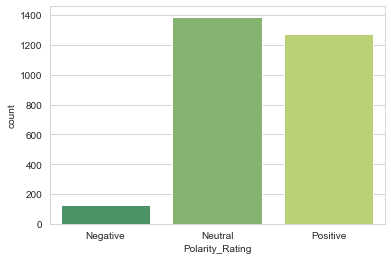

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df2, palette='summer')

In [6]:
print(df2['Polarity_Rating'].value_counts())

Neutral     1389
Positive    1271
Negative     128
Name: Polarity_Rating, dtype: int64


#2 Preprocesamiento

In [7]:
df2['content'] = df2['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
df2['content'] = df2['content'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros

In [8]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
df2['content'] = df2['content'].apply(lambda x : check_unique_char(conti_rep_char,x))
df2

,content,Polarity_Rating
0,como sabe la nutela,Negative
1,copia barata PA PA.. xd,Negative
2,copi paste!!!,Negative
3,Diana Novilo A penas y comparto par cosas de S...,Negative
4,Es aquelo que nl puedo poser,Neutral
...,...,...
2783,#RetoLaFavorita Aroz con huevo Sopa de camar...,Positive
2784,#NUESTRARECETALAFAVORITA MI SUEÑO ES PODER A ...,Neutral
2785,#NuestraRecetaLaFavorita Nuestro sueño en fami...,Neutral
2786,Uy que emoción desde hoy estaré muchísimo más ...,Positive


In [9]:
import emoji 

def get_mentions_processing(text):
    return " ".join(filter(lambda x:x[0]!='@', text.split())) #no mentions

def get_hashtags_processing(text):
    return " ".join(filter(lambda x:x[0]!='#', text.split())) #no hashtags

def get_emojis_processing(text):
    return str(emoji.demojize(text,language='es')).replace(":"," ") #cambia emojis a texto

def get_less3words_processing(text):
    return ' '.join([word for word in text.split() if len(word)>2]) #elimina palabras con menos de 3 caracteres

def get_text_processing(text):
    stpword = stopwords.words('spanish')
    non_words = list(punctuation) #considera ¿ y ¡
    non_words.extend(['¿', '¡'])
    no_punctuation = [char for char in text if char not in non_words] #elimina puntuacion
    no_punctuation = ''.join(no_punctuation).lower() #convierte en minuscula
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword]) #elimina stopwords

def normalize(s): #elimina las vocales con tilde
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [10]:
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = pd.DataFrame()
df3 = df2
df3['content'] = df2['content']
df3['Content_Review'] = df2['content'].apply(get_mentions_processing)
df3['Content_Review1'] = df3['Content_Review'].apply(get_hashtags_processing)
df3['Content_Review2'] = df3['Content_Review1'].apply(get_emojis_processing)
df3['Content_Review3'] = df3['Content_Review2'].apply(get_text_processing)
df3['Content_Review4'] = df3['Content_Review3'].apply(get_less3words_processing)
df3['Content_Review5'] = df3['Content_Review4'].apply(normalize)
df3

,content,Polarity_Rating,Content_Review,Content_Review1,Content_Review2,Content_Review3,Content_Review4,Content_Review5
0,Que rico la favorita lo mejor,Positive,Que rico la favorita lo mejor,Que rico la favorita lo mejor,Que rico la favorita lo mejor,rico favorita mejor,rico favorita mejor,rico favorita mejor
1,@victorbravo,Positive,,,,,,
2,#Receta para el.exito.como.quisiera ganar la f...,Neutral,#Receta para el.exito.como.quisiera ganar la f...,para el.exito.como.quisiera ganar la favorita ...,para el.exito.como.quisiera ganar la favorita ...,elexitocomoquisiera ganar favorita deposite ta...,elexitocomoquisiera ganar favorita deposite ta...,elexitocomoquisiera ganar favorita deposite ta...
3,"#ElijoDelilú porque tiene un sabor delicioso, ...",Positive,"#ElijoDelilú porque tiene un sabor delicioso, ...","porque tiene un sabor delicioso, perfecto para...","porque tiene un sabor delicioso, perfecto para...",sabor delicioso perfecto aperitivo además idea...,sabor delicioso perfecto aperitivo además idea...,sabor delicioso perfecto aperitivo ademas idea...
4,Todas queremos ganar ya deposité mis tapas.,Neutral,Todas queremos ganar ya deposité mis tapas.,Todas queremos ganar ya deposité mis tapas.,Todas queremos ganar ya deposité mis tapas.,todas queremos ganar deposité tapas,todas queremos ganar deposité tapas,todas queremos ganar deposite tapas
...,...,...,...,...,...,...,...,...
2783,Gracias aún disfruto de @deliluec 😍😘😍😘 enamora...,Positive,Gracias aún disfruto de 😍😘😍😘 enamorada de sus ...,Gracias aún disfruto de 😍😘😍😘 enamorada de sus ...,Gracias aún disfruto de cara_sonriendo_con_oj...,gracias aún disfruto carasonriendoconojosdecor...,gracias aún disfruto carasonriendoconojosdecor...,gracias aun disfruto carasonriendoconojosdecor...
2784,La Favorita aun se puede dejar las tapias??,Neutral,La Favorita aun se puede dejar las tapias??,La Favorita aun se puede dejar las tapias??,La Favorita aun se puede dejar las tapias??,favorita aun puede dejar tapias,favorita aun puede dejar tapias,favorita aun puede dejar tapias
2785,Disculpe para la fabricasa se ponen en sobres ...,Neutral,Disculpe para la fabricasa se ponen en sobres ...,Disculpe para la fabricasa se ponen en sobres ...,Disculpe para la fabricasa se ponen en sobres ...,disculpe fabricasa ponen sobres empaques sorte...,disculpe fabricasa ponen sobres empaques sorte...,disculpe fabricasa ponen sobres empaques sorte...
2786,"Estimada Evelyn, la promoción está vigente has...",Neutral,"Estimada Evelyn, la promoción está vigente has...","Estimada Evelyn, la promoción está vigente has...","Estimada Evelyn, la promoción está vigente has...",estimada evelyn promoción vigente,estimada evelyn promoción vigente,estimada evelyn promocion vigente


In [11]:
df4 = pd.DataFrame()
df4 = df3
df4 = df3[['Content_Review5', 'Polarity_Rating']]
print(df4.shape)
df4.head()

(2788, 2)


,Content_Review5,Polarity_Rating
0,rico favorita mejor,Positive
1,,Positive
2,elexitocomoquisiera ganar favorita deposite ta...,Neutral
3,sabor delicioso perfecto aperitivo ademas idea...,Positive
4,todas queremos ganar deposite tapas,Neutral


In [12]:
# Elimino registros con Answers NaN
df4['Content_Review5'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(df4['Content_Review5'].isna().sum()) 
df4 = df4.dropna(axis=0, subset=['Content_Review5'])
print(df4.shape)
df4

48
(2740, 2)


C:\Users\gpulg\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Content_Review5,Polarity_Rating
0,rico favorita mejor,Positive
2,elexitocomoquisiera ganar favorita deposite ta...,Neutral
3,sabor delicioso perfecto aperitivo ademas idea...,Positive
4,todas queremos ganar deposite tapas,Neutral
5,letra corecta buen aceite,Positive
...,...,...
2783,gracias aun disfruto carasonriendoconojosdecor...,Positive
2784,favorita aun puede dejar tapias,Neutral
2785,disculpe fabricasa ponen sobres empaques sorte...,Neutral
2786,estimada evelyn promocion vigente,Neutral


In [13]:
X=df4['Content_Review5'].values #se definen como valores
y=df4['Polarity_Rating'].values #se definen como valores

#Partición de la base entre testeo y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, random_state=42)

In [14]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2740,)
(2740,)
(1917,)
(822,)
(1917,)
(822,)


In [15]:
y_test

array(['Positive', 'Positive', 'Positive', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral',
       'Positive', 'Neutral', 'Negative', 'Positive', 'Positive',
       'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive',
       'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'Positive', 'Positive', 'Positive',
       'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral',
       'Positive', 'Neutral', 'Negative', 'Neutral', 'Positive',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral',
       'Negative', 'Neutral', '

In [16]:
vect1 = CountVectorizer(min_df=2,ngram_range=(1,1)) #transformo los X (values) en vectores 
X_train = vect1.fit_transform(X_train) 
X_test = vect1.transform(X_test)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1917, 1593)
(822, 1593)
(1917,)
(822,)


In [18]:
encoder = LabelBinarizer()  #Transformo los Y (values) en vectores
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [19]:
train_size=int(len(df4) * .7)              #permite la visualización más adelante en la matriz de confusión
test_tags=df4['Polarity_Rating'][train_size:] #permite la visualización más adelante en la matriz de confusión

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1917, 1593)
(822, 1593)
(1917, 3)
(822, 3)


In [21]:
tfidf = TfidfTransformer(smooth_idf=True,use_idf=True) #Entrega ponderación de importancia a palabras más "importantes" (frecuentes)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [22]:
# print idf values 
df_idf = pd.DataFrame(tfidf.idf_, index=vect1.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
favorita,2.678505
gracias,3.312014
aceite,3.561826
mejor,3.691504
siempre,3.763248
...,...
pasteles,7.460426
elegiria,7.460426
elaborarla,7.460426
educacion,7.460426


In [23]:
X_train.shape

(1917, 1593)

In [24]:
y_train.shape

(1917, 3)

In [25]:
#4.1 red aplicada
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()                                         #Se define estructura de la red capa por capa
model.add(Dense(units=1500, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=3,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(optimizer= 'adam' , loss= keras.losses.binary_crossentropy, metrics=['accuracy'])
model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics=METRICS)  #Se compila la red en conjunto a su optimizador


In [26]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=1)

Epoch 1/100
6/6 [==============================] - 6s 429ms/step - loss: 1.0594 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2682.0000 - fn: 1341.0000 - accuracy: 0.4265 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7135 - prc: 0.4819 - val_loss: 1.0075 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1152.0000 - val_fn: 576.0000 - val_accuracy: 0.4514 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7110 - val_prc: 0.4621
Epoch 2/100
6/6 [==============================] - 1s 95ms/step - loss: 0.9057 - tp: 106.0000 - fp: 91.0000 - tn: 2591.0000 - fn: 1235.0000 - accuracy: 0.5190 - precision: 0.5381 - recall: 0.0790 - auc: 0.7433 - prc: 0.5101 - val_loss: 0.8691 - val_tp: 255.0000 - val_fp: 311.0000 - val_tn: 841.0000 - val_fn: 321.0000 - val_accuracy: 0.4514 - val_precision: 0.4505 - val_recall: 0.4427 - val_auc: 0.7270 - val_prc: 0.4789
Epoch 3/100
6/6 [==============================] - 1s 97ms/step - loss: 0.8448 - tp: 665.0000 - fp: 617.0000 - tn: 2065.0000 - 

6/6 [==============================] - 1s 89ms/step - loss: 0.2703 - tp: 1196.0000 - fp: 108.0000 - tn: 2574.0000 - fn: 145.0000 - accuracy: 0.9001 - precision: 0.9172 - recall: 0.8919 - auc: 0.9805 - prc: 0.9659 - val_loss: 0.6592 - val_tp: 428.0000 - val_fp: 119.0000 - val_tn: 1033.0000 - val_fn: 148.0000 - val_accuracy: 0.7604 - val_precision: 0.7824 - val_recall: 0.7431 - val_auc: 0.9098 - val_prc: 0.8462
Epoch 21/100
6/6 [==============================] - 1s 86ms/step - loss: 0.2631 - tp: 1190.0000 - fp: 111.0000 - tn: 2571.0000 - fn: 151.0000 - accuracy: 0.8971 - precision: 0.9147 - recall: 0.8874 - auc: 0.9810 - prc: 0.9662 - val_loss: 0.6540 - val_tp: 430.0000 - val_fp: 127.0000 - val_tn: 1025.0000 - val_fn: 146.0000 - val_accuracy: 0.7604 - val_precision: 0.7720 - val_recall: 0.7465 - val_auc: 0.9117 - val_prc: 0.8501
Epoch 22/100
6/6 [==============================] - 1s 85ms/step - loss: 0.2339 - tp: 1200.0000 - fp: 95.0000 - tn: 2587.0000 - fn: 141.0000 - accuracy: 0.9045 -

6/6 [==============================] - 1s 89ms/step - loss: 0.1190 - tp: 1244.0000 - fp: 28.0000 - tn: 2654.0000 - fn: 97.0000 - accuracy: 0.9403 - precision: 0.9780 - recall: 0.9277 - auc: 0.9956 - prc: 0.9923 - val_loss: 0.9117 - val_tp: 431.0000 - val_fp: 128.0000 - val_tn: 1024.0000 - val_fn: 145.0000 - val_accuracy: 0.7622 - val_precision: 0.7710 - val_recall: 0.7483 - val_auc: 0.8946 - val_prc: 0.8176
Epoch 40/100
6/6 [==============================] - 1s 89ms/step - loss: 0.1094 - tp: 1254.0000 - fp: 21.0000 - tn: 2661.0000 - fn: 87.0000 - accuracy: 0.9478 - precision: 0.9835 - recall: 0.9351 - auc: 0.9967 - prc: 0.9940 - val_loss: 0.9189 - val_tp: 431.0000 - val_fp: 128.0000 - val_tn: 1024.0000 - val_fn: 145.0000 - val_accuracy: 0.7604 - val_precision: 0.7710 - val_recall: 0.7483 - val_auc: 0.8940 - val_prc: 0.8177
Epoch 41/100
6/6 [==============================] - 1s 91ms/step - loss: 0.1136 - tp: 1243.0000 - fp: 27.0000 - tn: 2655.0000 - fn: 98.0000 - accuracy: 0.9441 - prec

6/6 [==============================] - 1s 87ms/step - loss: 0.0930 - tp: 1252.0000 - fp: 12.0000 - tn: 2670.0000 - fn: 89.0000 - accuracy: 0.9709 - precision: 0.9905 - recall: 0.9336 - auc: 0.9977 - prc: 0.9960 - val_loss: 1.0937 - val_tp: 432.0000 - val_fp: 128.0000 - val_tn: 1024.0000 - val_fn: 144.0000 - val_accuracy: 0.7517 - val_precision: 0.7714 - val_recall: 0.7500 - val_auc: 0.8857 - val_prc: 0.8002
Epoch 59/100
6/6 [==============================] - 1s 88ms/step - loss: 0.0799 - tp: 1251.0000 - fp: 13.0000 - tn: 2669.0000 - fn: 90.0000 - accuracy: 0.9709 - precision: 0.9897 - recall: 0.9329 - auc: 0.9985 - prc: 0.9972 - val_loss: 1.1288 - val_tp: 429.0000 - val_fp: 130.0000 - val_tn: 1022.0000 - val_fn: 147.0000 - val_accuracy: 0.7448 - val_precision: 0.7674 - val_recall: 0.7448 - val_auc: 0.8850 - val_prc: 0.7995
Epoch 60/100
6/6 [==============================] - 1s 91ms/step - loss: 0.0862 - tp: 1250.0000 - fp: 14.0000 - tn: 2668.0000 - fn: 91.0000 - accuracy: 0.9717 - prec

6/6 [==============================] - 1s 88ms/step - loss: 0.0616 - tp: 1296.0000 - fp: 11.0000 - tn: 2671.0000 - fn: 45.0000 - accuracy: 0.9828 - precision: 0.9916 - recall: 0.9664 - auc: 0.9993 - prc: 0.9986 - val_loss: 1.2879 - val_tp: 432.0000 - val_fp: 142.0000 - val_tn: 1010.0000 - val_fn: 144.0000 - val_accuracy: 0.7500 - val_precision: 0.7526 - val_recall: 0.7500 - val_auc: 0.8813 - val_prc: 0.7868
Epoch 78/100
6/6 [==============================] - 1s 90ms/step - loss: 0.0574 - tp: 1304.0000 - fp: 18.0000 - tn: 2664.0000 - fn: 37.0000 - accuracy: 0.9843 - precision: 0.9864 - recall: 0.9724 - auc: 0.9993 - prc: 0.9987 - val_loss: 1.2941 - val_tp: 432.0000 - val_fp: 143.0000 - val_tn: 1009.0000 - val_fn: 144.0000 - val_accuracy: 0.7500 - val_precision: 0.7513 - val_recall: 0.7500 - val_auc: 0.8806 - val_prc: 0.7862
Epoch 79/100
6/6 [==============================] - 1s 94ms/step - loss: 0.0600 - tp: 1309.0000 - fp: 17.0000 - tn: 2665.0000 - fn: 32.0000 - accuracy: 0.9843 - prec

6/6 [==============================] - 1s 90ms/step - loss: 0.0572 - tp: 1312.0000 - fp: 19.0000 - tn: 2663.0000 - fn: 29.0000 - accuracy: 0.9828 - precision: 0.9857 - recall: 0.9784 - auc: 0.9991 - prc: 0.9983 - val_loss: 1.3990 - val_tp: 432.0000 - val_fp: 144.0000 - val_tn: 1008.0000 - val_fn: 144.0000 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8815 - val_prc: 0.7843
Epoch 97/100
6/6 [==============================] - 1s 91ms/step - loss: 0.0505 - tp: 1313.0000 - fp: 17.0000 - tn: 2665.0000 - fn: 28.0000 - accuracy: 0.9814 - precision: 0.9872 - recall: 0.9791 - auc: 0.9994 - prc: 0.9988 - val_loss: 1.4159 - val_tp: 432.0000 - val_fp: 134.0000 - val_tn: 1018.0000 - val_fn: 144.0000 - val_accuracy: 0.7500 - val_precision: 0.7633 - val_recall: 0.7500 - val_auc: 0.8810 - val_prc: 0.7828
Epoch 98/100
6/6 [==============================] - 1s 92ms/step - loss: 0.0528 - tp: 1317.0000 - fp: 19.0000 - tn: 2663.0000 - fn: 24.0000 - accuracy: 0.9843 - prec

In [27]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

13/13 [==============================] - 0s 11ms/step - loss: 1.1420 - tp: 637.0000 - fp: 149.0000 - tn: 1495.0000 - fn: 185.0000 - accuracy: 0.7835 - precision: 0.8104 - recall: 0.7749 - auc: 0.8958 - prc: 0.8103


In [76]:
#OPTIMIZER ALGORITHM
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, activation='relu'))
	model.add(Dense(3, activation='hard_sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.724283 using {'optimizer': 'Adamax'}
0.721192 (0.009090) with: {'optimizer': 'SGD'}
0.724002 (0.001733) with: {'optimizer': 'RMSprop'}
0.579820 (0.011465) with: {'optimizer': 'Adagrad'}
0.570264 (0.021610) with: {'optimizer': 'Adadelta'}
0.671726 (0.012341) with: {'optimizer': 'Adam'}
0.724283 (0.004819) with: {'optimizer': 'Adamax'}
0.669477 (0.007188) with: {'optimizer': 'Nadam'}


In [79]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [81]:
# Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, kernel_initializer='uniform', activation=activation))
	model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.703766 using {'activation': 'hard_sigmoid'}
0.699831 (0.006310) with: {'activation': 'softmax'}
0.682406 (0.006397) with: {'activation': 'softplus'}
0.667229 (0.007297) with: {'activation': 'softsign'}
0.675379 (0.003577) with: {'activation': 'relu'}
0.661046 (0.008789) with: {'activation': 'tanh'}
0.694210 (0.005167) with: {'activation': 'sigmoid'}
0.703766 (0.006757) with: {'activation': 'hard_sigmoid'}
0.663575 (0.005377) with: {'activation': 'linear'}


In [28]:
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()
model.add(Dense(units=1500, kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=3,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
model.compile(optimizer = 'Adamax',loss='categorical_crossentropy', metrics=METRICS)

In [29]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
6/6 [==============================] - 11s 1s/step - loss: 0.8975 - tp: 390.0000 - fp: 375.0000 - tn: 2691.0000 - fn: 1143.0000 - accuracy: 0.4286 - precision: 0.5098 - recall: 0.2544 - auc: 0.7178 - prc: 0.4856 - val_loss: 0.9164 - val_tp: 176.0000 - val_fp: 208.0000 - val_tn: 560.0000 - val_fn: 208.0000 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583 - val_auc: 0.7018 - val_prc: 0.4591
Epoch 2/100
6/6 [==============================] - 1s 97ms/step - loss: 0.8526 - tp: 780.0000 - fp: 753.0000 - tn: 2313.0000 - fn: 753.0000 - accuracy: 0.5088 - precision: 0.5088 - recall: 0.5088 - auc: 0.7266 - prc: 0.4813 - val_loss: 0.8747 - val_tp: 176.0000 - val_fp: 208.0000 - val_tn: 560.0000 - val_fn: 208.0000 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583 - val_auc: 0.7018 - val_prc: 0.4591
Epoch 3/100
6/6 [==============================] - 1s 98ms/step - loss: 0.8518 - tp: 281.0000 - fp: 299.0000 - tn: 2767.0000 - fn: 1252.0000 - accuracy: 0

6/6 [==============================] - 1s 97ms/step - loss: 0.8414 - tp: 719.0000 - fp: 673.0000 - tn: 2393.0000 - fn: 814.0000 - accuracy: 0.5088 - precision: 0.5165 - recall: 0.4690 - auc: 0.7500 - prc: 0.5331 - val_loss: 0.8713 - val_tp: 176.0000 - val_fp: 208.0000 - val_tn: 560.0000 - val_fn: 208.0000 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583 - val_auc: 0.7450 - val_prc: 0.5209
Epoch 21/100
6/6 [==============================] - 1s 96ms/step - loss: 0.8407 - tp: 621.0000 - fp: 563.0000 - tn: 2503.0000 - fn: 912.0000 - accuracy: 0.5095 - precision: 0.5245 - recall: 0.4051 - auc: 0.7445 - prc: 0.5245 - val_loss: 0.8685 - val_tp: 123.0000 - val_fp: 29.0000 - val_tn: 739.0000 - val_fn: 261.0000 - val_accuracy: 0.4583 - val_precision: 0.8092 - val_recall: 0.3203 - val_auc: 0.7566 - val_prc: 0.5411
Epoch 22/100
6/6 [==============================] - 1s 98ms/step - loss: 0.8416 - tp: 727.0000 - fp: 672.0000 - tn: 2394.0000 - fn: 806.0000 - accuracy: 0.5088 - prec

6/6 [==============================] - 1s 101ms/step - loss: 0.7476 - tp: 973.0000 - fp: 305.0000 - tn: 2761.0000 - fn: 560.0000 - accuracy: 0.7228 - precision: 0.7613 - recall: 0.6347 - auc: 0.8861 - prc: 0.7981 - val_loss: 0.7875 - val_tp: 242.0000 - val_fp: 55.0000 - val_tn: 713.0000 - val_fn: 142.0000 - val_accuracy: 0.7526 - val_precision: 0.8148 - val_recall: 0.6302 - val_auc: 0.8962 - val_prc: 0.8275
Epoch 40/100
6/6 [==============================] - 1s 99ms/step - loss: 0.7256 - tp: 1054.0000 - fp: 234.0000 - tn: 2832.0000 - fn: 479.0000 - accuracy: 0.7684 - precision: 0.8183 - recall: 0.6875 - auc: 0.9105 - prc: 0.8450 - val_loss: 0.7773 - val_tp: 240.0000 - val_fp: 88.0000 - val_tn: 680.0000 - val_fn: 144.0000 - val_accuracy: 0.7083 - val_precision: 0.7317 - val_recall: 0.6250 - val_auc: 0.8718 - val_prc: 0.7772
Epoch 41/100
6/6 [==============================] - 1s 100ms/step - loss: 0.7075 - tp: 1073.0000 - fp: 233.0000 - tn: 2833.0000 - fn: 460.0000 - accuracy: 0.7769 - p

6/6 [==============================] - 1s 99ms/step - loss: 0.4660 - tp: 1247.0000 - fp: 227.0000 - tn: 2839.0000 - fn: 286.0000 - accuracy: 0.8343 - precision: 0.8460 - recall: 0.8134 - auc: 0.9452 - prc: 0.9085 - val_loss: 0.5978 - val_tp: 283.0000 - val_fp: 82.0000 - val_tn: 686.0000 - val_fn: 101.0000 - val_accuracy: 0.7604 - val_precision: 0.7753 - val_recall: 0.7370 - val_auc: 0.9039 - val_prc: 0.8393
Epoch 59/100
6/6 [==============================] - 1s 98ms/step - loss: 0.4762 - tp: 1238.0000 - fp: 232.0000 - tn: 2834.0000 - fn: 295.0000 - accuracy: 0.8239 - precision: 0.8422 - recall: 0.8076 - auc: 0.9428 - prc: 0.9022 - val_loss: 0.6049 - val_tp: 279.0000 - val_fp: 87.0000 - val_tn: 681.0000 - val_fn: 105.0000 - val_accuracy: 0.7526 - val_precision: 0.7623 - val_recall: 0.7266 - val_auc: 0.9004 - val_prc: 0.8331
Epoch 60/100
6/6 [==============================] - 1s 100ms/step - loss: 0.4477 - tp: 1264.0000 - fp: 228.0000 - tn: 2838.0000 - fn: 269.0000 - accuracy: 0.8363 - p

6/6 [==============================] - 1s 100ms/step - loss: 0.4030 - tp: 1295.0000 - fp: 200.0000 - tn: 2866.0000 - fn: 238.0000 - accuracy: 0.8578 - precision: 0.8662 - recall: 0.8447 - auc: 0.9583 - prc: 0.9289 - val_loss: 0.6090 - val_tp: 277.0000 - val_fp: 88.0000 - val_tn: 680.0000 - val_fn: 107.0000 - val_accuracy: 0.7526 - val_precision: 0.7589 - val_recall: 0.7214 - val_auc: 0.9032 - val_prc: 0.8399
Epoch 78/100
6/6 [==============================] - 1s 100ms/step - loss: 0.3926 - tp: 1294.0000 - fp: 192.0000 - tn: 2874.0000 - fn: 239.0000 - accuracy: 0.8591 - precision: 0.8708 - recall: 0.8441 - auc: 0.9617 - prc: 0.9334 - val_loss: 0.5856 - val_tp: 283.0000 - val_fp: 86.0000 - val_tn: 682.0000 - val_fn: 101.0000 - val_accuracy: 0.7578 - val_precision: 0.7669 - val_recall: 0.7370 - val_auc: 0.9090 - val_prc: 0.8495
Epoch 79/100
6/6 [==============================] - 1s 102ms/step - loss: 0.3824 - tp: 1301.0000 - fp: 185.0000 - tn: 2881.0000 - fn: 232.0000 - accuracy: 0.8611 -

6/6 [==============================] - 1s 100ms/step - loss: 0.3544 - tp: 1319.0000 - fp: 171.0000 - tn: 2895.0000 - fn: 214.0000 - accuracy: 0.8728 - precision: 0.8852 - recall: 0.8604 - auc: 0.9674 - prc: 0.9447 - val_loss: 0.6007 - val_tp: 282.0000 - val_fp: 90.0000 - val_tn: 678.0000 - val_fn: 102.0000 - val_accuracy: 0.7526 - val_precision: 0.7581 - val_recall: 0.7344 - val_auc: 0.9083 - val_prc: 0.8503
Epoch 97/100
6/6 [==============================] - 1s 108ms/step - loss: 0.3566 - tp: 1315.0000 - fp: 169.0000 - tn: 2897.0000 - fn: 218.0000 - accuracy: 0.8695 - precision: 0.8861 - recall: 0.8578 - auc: 0.9668 - prc: 0.9433 - val_loss: 0.5978 - val_tp: 283.0000 - val_fp: 88.0000 - val_tn: 680.0000 - val_fn: 101.0000 - val_accuracy: 0.7474 - val_precision: 0.7628 - val_recall: 0.7370 - val_auc: 0.9085 - val_prc: 0.8510
Epoch 98/100
6/6 [==============================] - 1s 103ms/step - loss: 0.3601 - tp: 1316.0000 - fp: 174.0000 - tn: 2892.0000 - fn: 217.0000 - accuracy: 0.8689 -

In [30]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)

#print('Test accuracy:', score[1])

13/13 [==============================] - 0s 11ms/step - loss: 0.5350 - tp: 653.0000 - fp: 150.0000 - tn: 1494.0000 - fn: 169.0000 - accuracy: 0.8066 - precision: 0.8132 - recall: 0.7944 - auc: 0.9261 - prc: 0.8769


In [31]:
prediction = model.predict(X_test)

In [32]:
predictions = np.argmax(prediction, axis = 1)

In [33]:
predictions

array([2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2,

In [34]:
y_test_labels = np.argmax(y_test, axis =1)

In [35]:
y_test_labels

array([2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1,
       2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2,

In [36]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [37]:

from sklearn.utils import class_weight   #Estima los pesos de las clases
weight = class_weight.compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)
weight = {i : weight[i] for i in range(3)}
weight

C:\Users\gpulg\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.1, 1: 0.6684100418410042, 2: 0.7336394948335246}

In [38]:
num_epochs =200
batch_size = 256
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    class_weight=weight,   #con el class_weight le digo al modelo q tenga especial atencion con la clase sobre/infra representada 
                    validation_split=0.2)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
6/6 - 5s - loss: 0.8637 - tp: 1308.0000 - fp: 146.0000 - tn: 2920.0000 - fn: 225.0000 - accuracy: 0.8793 - precision: 0.8996 - recall: 0.8532 - auc: 0.9662 - prc: 0.9444 - val_loss: 0.6487 - val_tp: 264.0000 - val_fp: 64.0000 - val_tn: 704.0000 - val_fn: 120.0000 - val_accuracy: 0.7526 - val_precision: 0.8049 - val_recall: 0.6875 - val_auc: 0.8901 - val_prc: 0.8373
Epoch 2/200
6/6 - 1s - loss: 0.7116 - tp: 1162.0000 - fp: 81.0000 - tn: 2985.0000 - fn: 371.0000 - accuracy: 0.8793 - precision: 0.9348 - recall: 0.7580 - auc: 0.9599 - prc: 0.9390 - val_loss: 0.7551 - val_tp: 190.0000 - val_fp: 27.0000 - val_tn: 741.0000 - val_fn: 194.0000 - val_accuracy: 0.7552 - val_precision: 0.8756 - val_recall: 0.4948 - val_auc: 0.8691 - val_prc: 0.8219
Epoch 3/200
6/6 - 1s - loss: 0.7123 - tp: 1036.0000 - fp: 52.0000 - tn: 3014.0000 - fn: 497.0000 - accu

Epoch 22/200
6/6 - 1s - loss: 0.5562 - tp: 1185.0000 - fp: 173.0000 - tn: 2893.0000 - fn: 348.0000 - accuracy: 0.8050 - precision: 0.8726 - recall: 0.7730 - auc: 0.9431 - prc: 0.9198 - val_loss: 0.8384 - val_tp: 231.0000 - val_fp: 98.0000 - val_tn: 670.0000 - val_fn: 153.0000 - val_accuracy: 0.6328 - val_precision: 0.7021 - val_recall: 0.6016 - val_auc: 0.8327 - val_prc: 0.7716
Epoch 23/200
6/6 - 1s - loss: 0.5578 - tp: 1161.0000 - fp: 218.0000 - tn: 2848.0000 - fn: 372.0000 - accuracy: 0.7821 - precision: 0.8419 - recall: 0.7573 - auc: 0.9319 - prc: 0.9021 - val_loss: 0.8993 - val_tp: 230.0000 - val_fp: 107.0000 - val_tn: 661.0000 - val_fn: 154.0000 - val_accuracy: 0.6302 - val_precision: 0.6825 - val_recall: 0.5990 - val_auc: 0.8193 - val_prc: 0.7677
Epoch 24/200
6/6 - 1s - loss: 0.5423 - tp: 1197.0000 - fp: 132.0000 - tn: 2934.0000 - fn: 336.0000 - accuracy: 0.8180 - precision: 0.9007 - recall: 0.7808 - auc: 0.9474 - prc: 0.9250 - val_loss: 0.8167 - val_tp: 236.0000 - val_fp: 76.000

Epoch 44/200
6/6 - 1s - loss: 0.4409 - tp: 1239.0000 - fp: 169.0000 - tn: 2897.0000 - fn: 294.0000 - accuracy: 0.8304 - precision: 0.8800 - recall: 0.8082 - auc: 0.9551 - prc: 0.9329 - val_loss: 0.8820 - val_tp: 237.0000 - val_fp: 111.0000 - val_tn: 657.0000 - val_fn: 147.0000 - val_accuracy: 0.6406 - val_precision: 0.6810 - val_recall: 0.6172 - val_auc: 0.8350 - val_prc: 0.7761
Epoch 45/200
6/6 - 1s - loss: 0.4552 - tp: 1252.0000 - fp: 164.0000 - tn: 2902.0000 - fn: 281.0000 - accuracy: 0.8421 - precision: 0.8842 - recall: 0.8167 - auc: 0.9557 - prc: 0.9347 - val_loss: 0.8630 - val_tp: 253.0000 - val_fp: 85.0000 - val_tn: 683.0000 - val_fn: 131.0000 - val_accuracy: 0.6797 - val_precision: 0.7485 - val_recall: 0.6589 - val_auc: 0.8479 - val_prc: 0.7975
Epoch 46/200
6/6 - 1s - loss: 0.4608 - tp: 1255.0000 - fp: 137.0000 - tn: 2929.0000 - fn: 278.0000 - accuracy: 0.8461 - precision: 0.9016 - recall: 0.8187 - auc: 0.9563 - prc: 0.9334 - val_loss: 0.8579 - val_tp: 254.0000 - val_fp: 82.000

Epoch 66/200
6/6 - 1s - loss: 0.3817 - tp: 1241.0000 - fp: 205.0000 - tn: 2861.0000 - fn: 292.0000 - accuracy: 0.8245 - precision: 0.8582 - recall: 0.8095 - auc: 0.9541 - prc: 0.9285 - val_loss: 0.7865 - val_tp: 279.0000 - val_fp: 69.0000 - val_tn: 699.0000 - val_fn: 105.0000 - val_accuracy: 0.7526 - val_precision: 0.8017 - val_recall: 0.7266 - val_auc: 0.8783 - val_prc: 0.8275
Epoch 67/200
6/6 - 1s - loss: 0.3720 - tp: 1350.0000 - fp: 111.0000 - tn: 2955.0000 - fn: 183.0000 - accuracy: 0.8969 - precision: 0.9240 - recall: 0.8806 - auc: 0.9737 - prc: 0.9600 - val_loss: 0.8880 - val_tp: 246.0000 - val_fp: 102.0000 - val_tn: 666.0000 - val_fn: 138.0000 - val_accuracy: 0.6719 - val_precision: 0.7069 - val_recall: 0.6406 - val_auc: 0.8441 - val_prc: 0.7841
Epoch 68/200
6/6 - 1s - loss: 0.3677 - tp: 1267.0000 - fp: 158.0000 - tn: 2908.0000 - fn: 266.0000 - accuracy: 0.8545 - precision: 0.8891 - recall: 0.8265 - auc: 0.9617 - prc: 0.9405 - val_loss: 0.7831 - val_tp: 267.0000 - val_fp: 63.000

Epoch 88/200
6/6 - 1s - loss: 0.3348 - tp: 1304.0000 - fp: 165.0000 - tn: 2901.0000 - fn: 229.0000 - accuracy: 0.8669 - precision: 0.8877 - recall: 0.8506 - auc: 0.9644 - prc: 0.9431 - val_loss: 0.7841 - val_tp: 265.0000 - val_fp: 81.0000 - val_tn: 687.0000 - val_fn: 119.0000 - val_accuracy: 0.7292 - val_precision: 0.7659 - val_recall: 0.6901 - val_auc: 0.8787 - val_prc: 0.8246
Epoch 89/200
6/6 - 1s - loss: 0.3053 - tp: 1369.0000 - fp: 100.0000 - tn: 2966.0000 - fn: 164.0000 - accuracy: 0.9152 - precision: 0.9319 - recall: 0.8930 - auc: 0.9821 - prc: 0.9708 - val_loss: 0.8166 - val_tp: 260.0000 - val_fp: 90.0000 - val_tn: 678.0000 - val_fn: 124.0000 - val_accuracy: 0.7135 - val_precision: 0.7429 - val_recall: 0.6771 - val_auc: 0.8699 - val_prc: 0.8142
Epoch 90/200
6/6 - 1s - loss: 0.2863 - tp: 1333.0000 - fp: 116.0000 - tn: 2950.0000 - fn: 200.0000 - accuracy: 0.8865 - precision: 0.9199 - recall: 0.8695 - auc: 0.9764 - prc: 0.9623 - val_loss: 0.7810 - val_tp: 272.0000 - val_fp: 75.0000

Epoch 110/200
6/6 - 1s - loss: 0.2801 - tp: 1368.0000 - fp: 115.0000 - tn: 2951.0000 - fn: 165.0000 - accuracy: 0.9048 - precision: 0.9225 - recall: 0.8924 - auc: 0.9811 - prc: 0.9678 - val_loss: 0.7841 - val_tp: 269.0000 - val_fp: 84.0000 - val_tn: 684.0000 - val_fn: 115.0000 - val_accuracy: 0.7240 - val_precision: 0.7620 - val_recall: 0.7005 - val_auc: 0.8818 - val_prc: 0.8212
Epoch 111/200
6/6 - 1s - loss: 0.2518 - tp: 1344.0000 - fp: 126.0000 - tn: 2940.0000 - fn: 189.0000 - accuracy: 0.9008 - precision: 0.9143 - recall: 0.8767 - auc: 0.9799 - prc: 0.9666 - val_loss: 0.7903 - val_tp: 274.0000 - val_fp: 79.0000 - val_tn: 689.0000 - val_fn: 110.0000 - val_accuracy: 0.7318 - val_precision: 0.7762 - val_recall: 0.7135 - val_auc: 0.8827 - val_prc: 0.8222
Epoch 112/200
6/6 - 1s - loss: 0.2913 - tp: 1372.0000 - fp: 113.0000 - tn: 2953.0000 - fn: 161.0000 - accuracy: 0.9074 - precision: 0.9239 - recall: 0.8950 - auc: 0.9807 - prc: 0.9677 - val_loss: 0.8195 - val_tp: 266.0000 - val_fp: 91.0

Epoch 132/200
6/6 - 1s - loss: 0.2649 - tp: 1377.0000 - fp: 118.0000 - tn: 2948.0000 - fn: 156.0000 - accuracy: 0.9100 - precision: 0.9211 - recall: 0.8982 - auc: 0.9826 - prc: 0.9700 - val_loss: 0.7613 - val_tp: 275.0000 - val_fp: 84.0000 - val_tn: 684.0000 - val_fn: 109.0000 - val_accuracy: 0.7396 - val_precision: 0.7660 - val_recall: 0.7161 - val_auc: 0.8873 - val_prc: 0.8239
Epoch 133/200
6/6 - 1s - loss: 0.2353 - tp: 1374.0000 - fp: 117.0000 - tn: 2949.0000 - fn: 159.0000 - accuracy: 0.9106 - precision: 0.9215 - recall: 0.8963 - auc: 0.9827 - prc: 0.9701 - val_loss: 0.7902 - val_tp: 273.0000 - val_fp: 88.0000 - val_tn: 680.0000 - val_fn: 111.0000 - val_accuracy: 0.7318 - val_precision: 0.7562 - val_recall: 0.7109 - val_auc: 0.8846 - val_prc: 0.8206
Epoch 134/200
6/6 - 1s - loss: 0.2321 - tp: 1378.0000 - fp: 117.0000 - tn: 2949.0000 - fn: 155.0000 - accuracy: 0.9106 - precision: 0.9217 - recall: 0.8989 - auc: 0.9840 - prc: 0.9713 - val_loss: 0.7615 - val_tp: 275.0000 - val_fp: 87.0

Epoch 154/200
6/6 - 1s - loss: 0.2256 - tp: 1362.0000 - fp: 127.0000 - tn: 2939.0000 - fn: 171.0000 - accuracy: 0.9028 - precision: 0.9147 - recall: 0.8885 - auc: 0.9813 - prc: 0.9681 - val_loss: 0.7904 - val_tp: 277.0000 - val_fp: 87.0000 - val_tn: 681.0000 - val_fn: 107.0000 - val_accuracy: 0.7344 - val_precision: 0.7610 - val_recall: 0.7214 - val_auc: 0.8889 - val_prc: 0.8217
Epoch 155/200
6/6 - 1s - loss: 0.2309 - tp: 1404.0000 - fp: 109.0000 - tn: 2957.0000 - fn: 129.0000 - accuracy: 0.9243 - precision: 0.9280 - recall: 0.9159 - auc: 0.9856 - prc: 0.9750 - val_loss: 0.8469 - val_tp: 267.0000 - val_fp: 99.0000 - val_tn: 669.0000 - val_fn: 117.0000 - val_accuracy: 0.7109 - val_precision: 0.7295 - val_recall: 0.6953 - val_auc: 0.8738 - val_prc: 0.8061
Epoch 156/200
6/6 - 1s - loss: 0.2176 - tp: 1379.0000 - fp: 126.0000 - tn: 2940.0000 - fn: 154.0000 - accuracy: 0.9080 - precision: 0.9163 - recall: 0.8995 - auc: 0.9840 - prc: 0.9713 - val_loss: 0.7679 - val_tp: 278.0000 - val_fp: 81.0

Epoch 176/200
6/6 - 1s - loss: 0.2195 - tp: 1391.0000 - fp: 119.0000 - tn: 2947.0000 - fn: 142.0000 - accuracy: 0.9139 - precision: 0.9212 - recall: 0.9074 - auc: 0.9833 - prc: 0.9715 - val_loss: 0.7854 - val_tp: 274.0000 - val_fp: 99.0000 - val_tn: 669.0000 - val_fn: 110.0000 - val_accuracy: 0.7214 - val_precision: 0.7346 - val_recall: 0.7135 - val_auc: 0.8902 - val_prc: 0.8200
Epoch 177/200
6/6 - 1s - loss: 0.2434 - tp: 1375.0000 - fp: 127.0000 - tn: 2939.0000 - fn: 158.0000 - accuracy: 0.9061 - precision: 0.9154 - recall: 0.8969 - auc: 0.9814 - prc: 0.9683 - val_loss: 0.7966 - val_tp: 273.0000 - val_fp: 91.0000 - val_tn: 677.0000 - val_fn: 111.0000 - val_accuracy: 0.7292 - val_precision: 0.7500 - val_recall: 0.7109 - val_auc: 0.8846 - val_prc: 0.8151
Epoch 178/200
6/6 - 1s - loss: 0.2322 - tp: 1388.0000 - fp: 118.0000 - tn: 2948.0000 - fn: 145.0000 - accuracy: 0.9132 - precision: 0.9216 - recall: 0.9054 - auc: 0.9873 - prc: 0.9775 - val_loss: 0.8386 - val_tp: 268.0000 - val_fp: 102.

Epoch 198/200
6/6 - 1s - loss: 0.2479 - tp: 1391.0000 - fp: 117.0000 - tn: 2949.0000 - fn: 142.0000 - accuracy: 0.9165 - precision: 0.9224 - recall: 0.9074 - auc: 0.9851 - prc: 0.9738 - val_loss: 0.8960 - val_tp: 265.0000 - val_fp: 106.0000 - val_tn: 662.0000 - val_fn: 119.0000 - val_accuracy: 0.7005 - val_precision: 0.7143 - val_recall: 0.6901 - val_auc: 0.8711 - val_prc: 0.7953
Epoch 199/200
6/6 - 1s - loss: 0.2235 - tp: 1368.0000 - fp: 138.0000 - tn: 2928.0000 - fn: 165.0000 - accuracy: 0.8982 - precision: 0.9084 - recall: 0.8924 - auc: 0.9816 - prc: 0.9680 - val_loss: 0.8019 - val_tp: 278.0000 - val_fp: 91.0000 - val_tn: 677.0000 - val_fn: 106.0000 - val_accuracy: 0.7292 - val_precision: 0.7534 - val_recall: 0.7240 - val_auc: 0.8867 - val_prc: 0.8135
Epoch 200/200
6/6 - 1s - loss: 0.2150 - tp: 1394.0000 - fp: 115.0000 - tn: 2951.0000 - fn: 139.0000 - accuracy: 0.9132 - precision: 0.9238 - recall: 0.9093 - auc: 0.9868 - prc: 0.9765 - val_loss: 0.8245 - val_tp: 271.0000 - val_fp: 102

In [39]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

13/13 [==============================] - 0s 13ms/step - loss: 0.7456 - tp: 613.0000 - fp: 186.0000 - tn: 1458.0000 - fn: 209.0000 - accuracy: 0.7579 - precision: 0.7672 - recall: 0.7457 - auc: 0.9046 - prc: 0.8459


In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

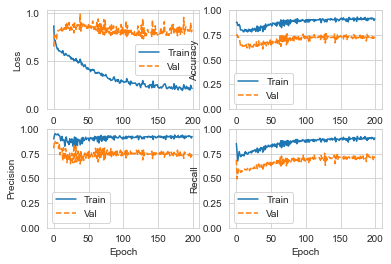

In [41]:
plot_metrics(history)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
class_weight

Actual label:Positive
Predicted label: Positive
Actual label:Neutral
Predicted label: Negative
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Neutral
Actual label:Positive
Predicted label: Neutral
Actual label:Positive
Predicted label: Positive
Actual label:Positive
Predicted label: Neutral
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Negative
Actual label:Neutral
Predicted label: Positive
Normalized confusion matrix


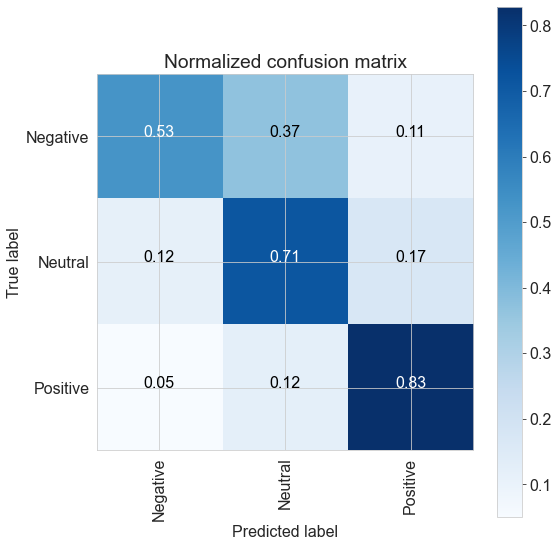

In [42]:
from sklearn.metrics import confusion_matrix
text_labels = encoder.classes_
label_names=['Negative','Neutral','Positive']

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix

fig = plt.figure()
fig.set_size_inches(8, 8, forward=True)
plt.rcParams.update({'font.size': 16})
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [81]:
encoder.inverse_transform(y_test)

array(['Positive', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Positive'], dtype='<U8')

***Deployment***

In [123]:
delilu= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsdelilu.xlsx')
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
0,253,4,5385637364812223_5389760717733221,NaN,2021-04-02 09:10:48,0.0,1.0
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
2,255,4,5385637364812223_5391709464205013,NaN,2021-04-02 18:27:53,1.0,1.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0


In [124]:
delilu.dropna(inplace=True)
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0


In [125]:
delilu['message'] = delilu['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
delilu['message'] = delilu['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [126]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
delilu['message'] = delilu['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
delilu

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,son ricas ya me compre un par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note estoy en las nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,Wow👌,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,que asco de momo,2018-06-23 15:14:10,0.0,0.0


In [127]:
delilu['message']
delilu['message'] = delilu['message'].apply(get_mentions_processing)
delilu['message']= delilu['message'].apply(get_hashtags_processing)
delilu['message'] = delilu['message'].apply(get_emojis_processing)
delilu['message'] = delilu['message'].apply(get_text_processing)
delilu['message']= delilu['message'].apply(get_less3words_processing)
delilu['message'] = delilu['message'].apply(normalize)
delilu[['message']]

,message
1,
3,carasonriendoconcorazones
4,daniela gilces
5,gusta delilu carasonriendoconcuernos caraconca...
6,lei vine lulu
...,...
3896,ricas compre par
3897,note nubes
3898,wow señaldeaprobacionconlamano
3899,asco momo


In [129]:
delilu['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(delilu['message'].isna().sum()) 
delilu.dropna(axis=0, subset=['message'],inplace=True)
print(delilu.shape)
delilu

0
(2571, 7)


,id,parent_id,object_id,message,created_time,like_count,comment_count
3,256,4,5385637364812223_5400254766683816,carasonriendoconcorazones,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,daniela gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,gusta delilu carasonriendoconcuernos caraconca...,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,lei vine lulu,2021-03-08 11:55:28,0.0,1.0
7,272,10,5260235984019029_5275846755791285,nunca falte delilu,2021-03-08 12:09:19,0.0,0.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,ricas compre par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,wow señaldeaprobacionconlamano,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,asco momo,2018-06-23 15:14:10,0.0,0.0


In [130]:
textos=delilu['message'].values
textos.shape


(2571,)

In [131]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [132]:
preddelilu = model.predict(X_deploy)

In [133]:
preddelilu

array([[1.0215026e-05, 9.9987113e-01, 1.1864152e-04],
       [9.6325672e-01, 2.3513781e-02, 1.3229430e-02],
       [5.7554539e-09, 1.6162552e-02, 9.8383743e-01],
       ...,
       [1.9071965e-06, 9.8384780e-01, 1.6150311e-02],
       [9.8802060e-01, 1.1772936e-02, 2.0643907e-04],
       [1.3265784e-05, 9.9943501e-01, 5.5170699e-04]], dtype=float32)

In [134]:
sentimientos=encoder.inverse_transform(preddelilu)
sentimientos

array(['Neutral', 'Negative', 'Positive', ..., 'Neutral', 'Negative',
       'Neutral'], dtype='<U8')

In [135]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Neutral
1,Negative
2,Positive
3,Negative
4,Positive
...,...
2566,Positive
2567,Negative
2568,Neutral
2569,Negative


In [136]:
delilu['sentiment']=label['label']

AttributeError: 'AxesSubplot' object has no property 'fontsize'

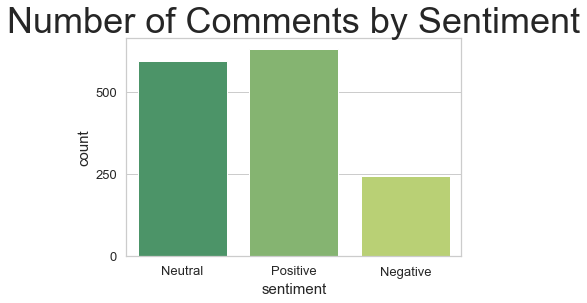

In [183]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
a=sns.countplot(x='sentiment',data=delilu, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment",fontsize=20)

La favorita

In [162]:
favorita= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsfavorita.xlsx')
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [164]:
favorita.dropna(inplace=True)
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [165]:
favorita['message'] = favorita['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
favorita['message'] = favorita['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [166]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
favorita['message'] = favorita['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
favorita

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebolado de...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,🥰,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,🥰,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,🥰,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,🥳,2020-11-17 17:08:28


In [167]:
favorita['message']
favorita['message'] = favorita['message'].apply(get_mentions_processing)
favorita['message']= favorita['message'].apply(get_hashtags_processing)
favorita['message'] = favorita['message'].apply(get_emojis_processing)
favorita['message'] = favorita['message'].apply(get_text_processing)
favorita['message']= favorita['message'].apply(get_less3words_processing)
favorita['message'] = favorita['message'].apply(normalize)
favorita[['message']]

,message
0,rico encebolado albacora preparado aceite favo...
1,ricas empanadas polo carne venta emprendimient...
2,participando exquisito yapingacho preparado am...
3,delicioso moro mixto polo chancho chuzo cuenca...
4,hamburguesa hamburguesa hamburguesa kleber ale...
...,...
8975,carasonriendoconcorazones
8976,carasonriendoconcorazones
8977,carasonriendoconcorazones
8978,caradefiesta


In [168]:
favorita['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(favorita['message'].isna().sum()) 
favorita.dropna(axis=0, subset=['message'],inplace=True)
print(favorita.shape)
favorita

309
(8671, 5)


,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,rico encebolado albacora preparado aceite favo...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,ricas empanadas polo carne venta emprendimient...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,participando exquisito yapingacho preparado am...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,delicioso moro mixto polo chancho chuzo cuenca...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,hamburguesa hamburguesa hamburguesa kleber ale...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,carasonriendoconcorazones,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,carasonriendoconcorazones,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,carasonriendoconcorazones,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,caradefiesta,2020-11-17 17:08:28


In [169]:
textos=favorita['message'].values
textos.shape

(8671,)

In [170]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [174]:
predfav = model.predict(X_deploy)

In [175]:
sentimientos=encoder.inverse_transform(predfav)
sentimientos

array(['Positive', 'Positive', 'Positive', ..., 'Neutral', 'Positive',
       'Positive'], dtype='<U8')

In [176]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Positive
1,Positive
2,Positive
3,Positive
4,Neutral
...,...
8666,Neutral
8667,Neutral
8668,Neutral
8669,Positive


In [177]:
favorita['sentiment']=label['label']

[Text(0.5, 1.0, 'Number of Comments by Sentiment')]

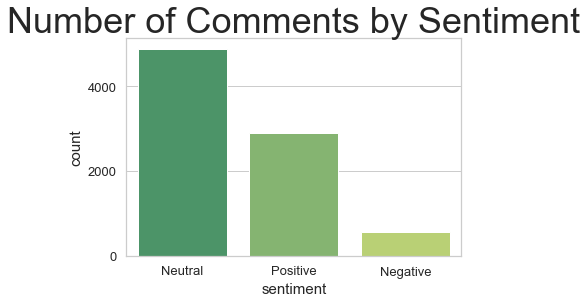

In [182]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
sns.countplot(x='sentiment',data=favorita, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment")